In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sktime.forecasting.ets import AutoETS
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from math import *
import sys
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly 
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# pycaret에서 나온 best들 
# 민수용. ETS/ Theta Forecaster, seasonal naive forecaster, arima, lgbm
# 산업용  ETS, theta forecaster, seasonal naive forecaster, arima, lgbm 
# 총합 : ETS/exponential smoothing, seasonal naive forecaster, lgbm, arima 

In [2]:
df = pd.read_csv('../../0_data/newdata/new_df_00.csv')

In [3]:
df.head(3)

,date,year,month,RP,GAS_PRICE,OIL_PRICE,도시가스_민수용,도시가스_산업용,도시가스_총합,민수용비중,...,명누적성장율,명GDP0.8성장율,명0.8누적성장율,QVA_origin,yearmonth,holirate,month4,month3,cumhouse,kospi_float
0,1996-01-01,1996,1,0.97,26.94,27.86,605519.0,83809.0,689328.0,0.87842,...,11.0,11.0,11.0,36550.3,199601,0.322581,3,2,592132.0,878.82
1,1996-02-01,1996,2,0.93,26.94,29.04,566323.0,70427.0,636750.0,0.88940,...,11.0,11.0,11.0,36550.3,199602,0.344828,3,2,592132.0,852.83
2,1996-03-01,1996,3,0.96,26.94,27.99,477514.0,62652.0,540166.0,0.88401,...,11.0,11.0,11.0,36550.3,199603,0.354839,1,2,592132.0,874.16


In [4]:
df.columns

Index(['date', 'year', 'month', 'RP', 'GAS_PRICE', 'OIL_PRICE', '도시가스_민수용',
       '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA',
       'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', 'GDP', '성장율',
       '누적성장율', 'GDP0.8', '명GDP성장율', '명누적성장율', '명GDP0.8성장율', '명0.8누적성장율',
       'QVA_origin', 'yearmonth', 'holirate', 'month4', 'month3', 'cumhouse',
       'kospi_float'],
      dtype='object')

In [5]:
df.drop(['RP'], axis=1, inplace=True)

In [6]:
#rp만 갈아끼우기
rp = pd.read_csv('../../0_data/newdata/gasoilprice/gas_oil_rp_v3.csv')

In [7]:
rp.columns

Index(['date', 'GAS_PRICE', 'OIL_PRICE', 'RP'], dtype='object')

In [8]:
rp = rp[['date','RP']]

In [9]:
df1 = pd.merge(df,rp, how='outer',on='date')

In [10]:
df1.columns

Index(['date', 'year', 'month', 'GAS_PRICE', 'OIL_PRICE', '도시가스_민수용',
       '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA',
       'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', 'GDP', '성장율',
       '누적성장율', 'GDP0.8', '명GDP성장율', '명누적성장율', '명GDP0.8성장율', '명0.8누적성장율',
       'QVA_origin', 'yearmonth', 'holirate', 'month4', 'month3', 'cumhouse',
       'kospi_float', 'RP'],
      dtype='object')

In [11]:
df1.head(3)

,date,year,month,GAS_PRICE,OIL_PRICE,도시가스_민수용,도시가스_산업용,도시가스_총합,민수용비중,산업용비중,...,명GDP0.8성장율,명0.8누적성장율,QVA_origin,yearmonth,holirate,month4,month3,cumhouse,kospi_float,RP
0,1996-01-01,1996,1,26.94,27.86,605519.0,83809.0,689328.0,0.87842,0.12158,...,11.0,11.0,36550.3,199601,0.322581,3,2,592132.0,878.82,0.97
1,1996-02-01,1996,2,26.94,29.04,566323.0,70427.0,636750.0,0.88940,0.11060,...,11.0,11.0,36550.3,199602,0.344828,3,2,592132.0,852.83,0.93
2,1996-03-01,1996,3,26.94,27.99,477514.0,62652.0,540166.0,0.88401,0.11599,...,11.0,11.0,36550.3,199603,0.354839,1,2,592132.0,874.16,0.96


df1.to_csv('../../0_data/newdata/new_df_00_rp3.csv',index=False)

In [12]:
df2 = df1.copy()

# 산업용
* 현재 best 모델에 RP, GAS_PRICE, OIP_PRICE 등 갈아끼워보기
* Exponential smoothing _sp=48 *0.8 , 현재 best

In [13]:
df1['year']=pd.to_datetime(df1['year'])
df1 = df1.loc[:299]
df1['도시가스_총합'] = df1['도시가스_총합'].astype(int)
df1['도시가스_민수용'] = df1['도시가스_민수용'].astype(int)
df1['도시가스_산업용'] = df1['도시가스_산업용'].astype(int)
fh = list(range(1,169))

mean: 841821.4623611314 528199.3908484116 1362622.748228815
# best 조합
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=48)  

mean: 841023.1123528046 min: 499594.8352278117 max: 1430462.8580230735


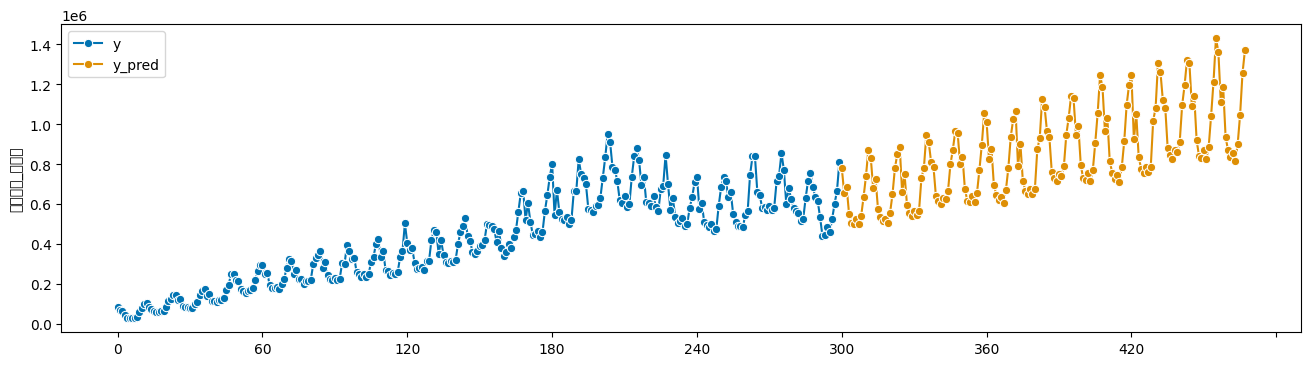

In [14]:
y = df1['도시가스_산업용'] 
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=48)  
# multiplicative / additive
forecaster.fit(y)
ExponentialSmoothing(...)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["y", "y_pred"])
print("mean:",y_pred.mean(), "min:",y_pred.min(), "max:",y_pred.max())

## multi_prophet 

In [ ]:
df2["value"] = df2["도시가스_산업용"]
df2 = df2[:300]
list(map(lambda x:x.split('-')[0]+x.split('-')[1],df['date']))
df1 = df2[['date','value','kospi_float', 'OIL_PRICE', 'people', 'GDP', 'QVA_origin']] 
train_df = df1.copy()
#date,value 포함 그 외 피처 알아서
y_train_prophet_df = train_df[['date','value']]
y_train_prophet_df.columns = ['ds', 'y']
y_train_prophet_df.head()

x_col = [i for i in train_df.columns if i not in ['date','value']] 
x_train_prophet_df = train_df[x_col] 
x_train_prophet_df.head()

 param_grid = {  
'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
'seasonality_mode': ['multiplicative', 'additive'],
'growth': ['linear', 'logistic'],
'yearly_seasonality':[5,10,20,40],
'weekly_seasonality':[5,10,20,40],
'daily_seasonality':[5,10,20,40],
}

# best 조합
m = Prophet(seasonality_mode='additive', n_changepoints=10, mcmc_samples=300, changepoint_prior_scale=0.025, yearly_seasonality='auto',changepoint_range=0.5).fit(yx_train_prophet_df)  #, sh

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
scaler.fit(x_train_prophet_df[['kospi_float', 'OIL_PRICE', 'people', 'GDP', 'QVA_origin']])  
trans_colum = scaler.transform(x_train_prophet_df[['kospi_float', 'OIL_PRICE', 'people', 'GDP', 'QVA_origin']])  

x_train_prophet_df['kospi_float'] = [trans_colum[i][0] for i in range(len(trans_colum))]
x_train_prophet_df['OIL_PRICE'] = [trans_colum[i][1] for i in range(len(trans_colum))]
x_train_prophet_df['people'] = [trans_colum[i][2] for i in range(len(trans_colum))]
x_train_prophet_df['GDP'] = [trans_colum[i][3] for i in range(len(trans_colum))]
x_train_prophet_df['QVA_origin'] = [trans_colum[i][3] for i in range(len(trans_colum))]

yx_train_prophet_df = pd.concat([y_train_prophet_df, x_train_prophet_df],axis = 1)

m = Prophet(seasonality_mode='additive', n_changepoints=10, mcmc_samples=300, changepoint_prior_scale=0.025, yearly_seasonality='auto',changepoint_range=0.5).fit(yx_train_prophet_df)  #, show_progress=False) #0.001
# 여기 수정
future = m.make_future_dataframe(periods=168, freq='MS')
fcst = m.predict(future)
fig = m.plot_components(fcst)

In [ ]:
# 모델 저장(score:134,303)
import pickle
pkl_path = "../../2_second_model/saved_model/Ann/san4.pkl"
with open(pkl_path, "wb") as f:    
    pickle.dump(m, f)
# read the Prophet model object
with open(pkl_path, 'rb') as f:
    san_qva_kospi2 = pickle.load(f)
fig = san_qva_kospi2.plot(fcst, figsize=(20,10), xlabel='year-month', ylabel='reward amount')

In [ ]:
# 현재 파일
print(fcst['yhat'][-168:].mean(),fcst['yhat'][-168:].min(),fcst['yhat'][-168:].max())

# best 조합
sub['IND'] =y_pred.values*0.82+fcst['yhat'][-168:].values*0.18
841681.4205757922 525347.1564351048 1368964.2921524532

In [ ]:
sub = pd.read_csv('../../0_data/rawdata/submission_sample.csv')
sub['IND'] =y_pred.values*0.82+fcst['yhat'][-168:].values*0.18
print(sub['IND'].mean(), sub['IND'].min(),sub['IND'].max())

In [ ]:
sub['IND'].plot()

In [ ]:
print(sub['IND'].mean(), sub['IND'].min(),sub['IND'].max()) #790471.1890171387

# best 조합

sub = pd.read_csv('../../0_data/rawdata/submission_sample.csv')

In [ ]:
#민수용 best
compare = pd.read_csv('../../0_data/newdata/1_prophet_uni/reverse_model')
sub['CIVIL'] = compare['CIVIL'].copy()
print(sub['CIVIL'].mean(), sub['CIVIL'].min(),sub['CIVIL'].max())

#산업용 best
san = pd.read_csv('../../3_submit/Ann/san2.csv')
sub['IND'] = san['IND'].copy()
print(sub['IND'].mean(), sub['IND'].min(),sub['IND'].max())

In [ ]:
sub['CIVIL'].plot()

In [ ]:
sub['IND'].plot()

In [ ]:
sub.to_csv('../../3_submit/Ann/san4.csv',index=False)

In [ ]:
## 끝